In [1]:
import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
from scipy.ndimage import gaussian_filter

In [2]:
def lsst_srd_galaxy_clustering_2pt(cosmo, year):
    # cosmo is a ccl cosmology object
    # binning etc is set to 5 z bins for y1 (10 for y10) and 20 ell bins with cutoff at high ell like in the SRD and Tim's cosmoliek code
    if year=='Y1' or year==1 or year=='y1':
        nbin_z = 5
        z0 = 0.26
        alpha = 0.94
        sig_z = 0.03
        Ngal = 18 # Normalisation, galaxies/arcmin^2
        linear_bias = np.array([1.562362, 1.732963, 1.913252, 2.100644, 2.293210])
    else:
        print('only Y1 implemented currently')
        
    bin_edges = np.linspace(0.2, 1.2, nbin_z+1)
    bin_low_zs = bin_edges[:-1]
    bin_high_zs = bin_edges[1:]
    zmids = (bin_low_zs+bin_high_zs)/2
        
    nbin_ell = 20 
    ell_edges = np.geomspace(20, 15000, nbin_ell+1)
    ell_centers_lin = (ell_edges[0:-1]+ell_edges[1:])/2
    
    chis = ccl.comoving_radial_distance(cosmo, 1/(1+zmids)) # Mpc
    kmax = 0.3*h
    lmax = kmax*chis-0.5
    
    z= np.linspace(0., 3., 1001)
    #redshift distribution normalized to galaxy number density
    pz = (z / z0)**2. * np.exp(-(z / z0)**alpha) # Redshift distribution, p(z)
    norm = Ngal/np.trapz(pz, z)
    dNdz = norm * pz # Number density distribution
    
    tracers = []
    for i, zmin in enumerate(bin_low_zs):
        zmax = bin_high_zs[i]
        zmid = zmids[i]
        dndz_bin = np.zeros_like(z)
        dndz_bin[(z>zmin) & (z<zmax)] = dNdz[(z>zmin) & (z<zmax)]
        dz = z[1]-z[0]
        dndz_bin = gaussian_filter(dndz_bin, sig_z*(1+zmid)/dz)
        galaxy_tracer_bin = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dndz_bin), bias=(zmids,linear_bias), mag_bias=None)
        tracers.append(galaxy_tracer_bin)
        
    ell = np.arange(2, 20000)
    # assuming tophat ell binning
    datavector = np.zeros((nbin_ell*nbin_z, 2))
    for i in range(nbin_z):
        datavector[0:10]
        datavector[0:100]
        cl_zbin = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell)
        num_lbins_linear_scales = np.sum(ell_centers_lin<lmax[i]) #from kmax=0.3 h / Mpc criterion    
        for j, ell_j in enumerate(ell_centers_lin):
            datavector[i*nbin_ell+j, 0]=ell_j
            if ell_j<lmax[i]:
                datavector[i*nbin_ell+j, 1] = np.mean(cl_zbin[(ell>ell_edges[j]) & (ell<=ell_edges[j+1])])
    return datavector

Text(0.5, 1.0, 'Galaxy clustering C($\\ell$) for 5 redshift bins (LSST Y1)')

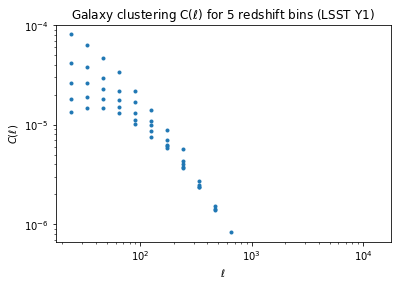

In [3]:
h=0.6727
cosmo_fid_srd = ccl.Cosmology(
    Omega_c=0.2664315,
    Omega_b=0.0491685,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
    sigma8 = 0.831,
    n_s=0.9645,
    h=h,
)

datavector_y1_fid = lsst_srd_galaxy_clustering_2pt(cosmo_fid_srd, year='Y1')
plt.loglog(datavector_y1_fid[:,0], datavector_y1_fid[:,1], '.')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.title('Galaxy clustering C($\ell$) for 5 redshift bins (LSST Y1)')

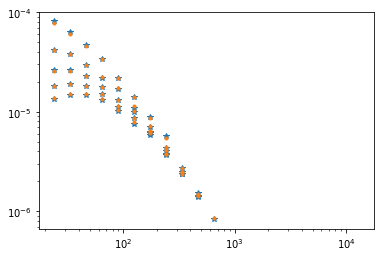

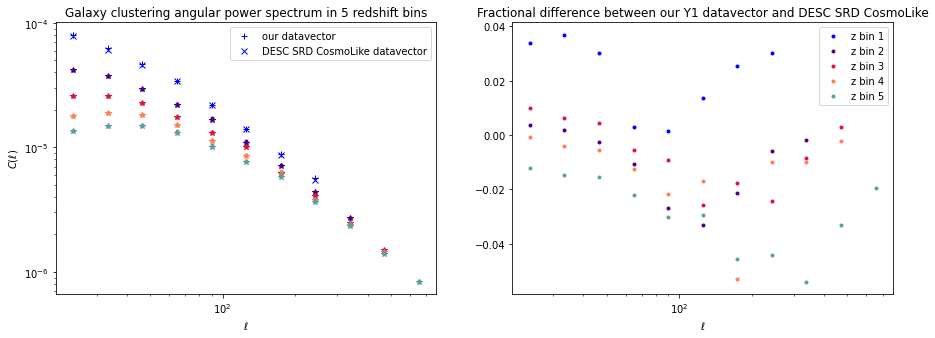

In [4]:
#compare cosmolike
clike_dir = '/Users/heatherp/Documents/DESC_SRD/CosmoLike-DESC_SRD-master/'
lss_y1_cosmolike = np.loadtxt(clike_dir+'datav/pos_pos_Y1_fid')

plt.loglog(datavector_y1_fid[:,0], datavector_y1_fid[:,1],  '*' )
plt.loglog(datavector_y1_fid[:,0], lss_y1_cosmolike[:,1],  '.')
plt.show()

nbinz=5
nbin_ell=20
colors=['blue', 'indigo', 'crimson', 'coral', 'cadetblue']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for i in range(nbinz):
    i1 = i*nbin_ell
    num_nonzero=np.sum(datavector_y1_fid[i1:i1+nbin_ell,1]>0)
    i2=i1+num_nonzero
    if i==0:
        ax1.loglog(datavector_y1_fid[i1:i2,0], datavector_y1_fid[i1:i2,1],  '+', color=colors[i], label='our datavector')
        ax1.loglog(datavector_y1_fid[i1:i2,0], lss_y1_cosmolike[i1:i2,1],  'x', color=colors[i], label='DESC SRD CosmoLike datavector')
    else:
        ax1.loglog(datavector_y1_fid[i1:i2,0], datavector_y1_fid[i1:i2,1],  '*', color=colors[i])
        ax1.loglog(datavector_y1_fid[i1:i2,0], lss_y1_cosmolike[i1:i2,1],  '.', color=colors[i])


    ax2.plot(datavector_y1_fid[i1:i2,0], (datavector_y1_fid[i1:i2,1]-lss_y1_cosmolike[i1:i2,1])/datavector_y1_fid[i1:i2,1], marker='.', linestyle='none', color=colors[i], label='z bin '+str(1+i))
ax1.legend()
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C(\ell)$')
ax1.set_title('Galaxy clustering angular power spectrum in 5 redshift bins')
plt.legend()
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.title('Fractional difference between our Y1 datavector and DESC SRD CosmoLike')
plt.show()